<a href="https://colab.research.google.com/github/18520076Khiem/CS114.K21/blob/master/Case_Study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Danh sách thành viên**
- 18521404 Lê Đại Thành
- 18520076 Trần Đỗ Quốc Khiêm
- 18521394 Nguyễn Hoàng Thắng


#**Mô tả bài toán**
-Giới thiệu bài toán: Hiện nay số lượng thông tin rất nhiều.Vấn nạn về việc lựa chọn tin tức chính xác để đọc là một vấn đề rất nan giải. Cho nên việc phân biệt đâu là thông tin chính thống đâu là thông tin châm biếm để không bị nhầm lẫn thật sự cần thiết. Do đó ý tưởng để cho máy tính có thể phân biệt đâu là thông tin chính xác có thể hữu dụng.

- Phát biểu bài toán: Dự đoán bài báo có phải thông tin chính thống hay là thông tin có tính chất mỉa mai châm biếm dựa vào tiêu đề của bài báo

- Thu thập dữ liệu data: Dựa trên hai trang web tin tức đó là:
    - TheOnion chuyên về những tin tức có tính châm biến không chính thống
    - HuffPost chuyên về những tin tức chính thống 
    - Nội dung dữ liệu bao gồm ba thuộc tính:
      - is_sarcastic:
        - 1 nếu dữ liệu là tin có tính châm biếm mỉa mai
        - 0 nếu dữ liệu là tin chính thống
      - headline: là tiêu đề của những bài báo
      - article_link: liên kết đến bài báo đó
- Input: Tiêu đề của bài báo.

- Output: Bài báo có tính châm biếm hay không

#**Các thư viện được sử dụng trong bài toán**

In [3]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#**Lấy datasets trên Kaggle**


###Lấy và giải nén file data từ kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trandoquockhiem","key":"94f23ee7b4ed300f910aada801fc5b46"}'}

In [6]:
!pip install kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list -s headlines

ref                                                  title                                          size  lastUpdated          downloadCount  
---------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
therohk/million-headlines                            A Million News Headlines                       20MB  2020-04-27 13:07:30           1336  
rmisra/news-headlines-dataset-for-sarcasm-detection  News Headlines Dataset For Sarcasm Detection    3MB  2019-07-03 23:52:57           9701  
therohk/india-headlines-news-dataset                 India Headlines News Dataset                   68MB  2019-04-12 02:46:04           1995  
aaron7sun/stocknews                                  Daily News for Stock Market Prediction          6MB  2019-11-13 18:22:52           4204  
rmisra/news-category-dataset                         News Category Dataset                          25MB  2018-12-02 04:09:45          11521  

In [8]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 111MB/s]


In [9]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [10]:
ls

kaggle.json
news-headlines-dataset-for-sarcasm-detection.zip
sample_data/
Sarcasm_Headlines_Dataset.json
Sarcasm_Headlines_Dataset_v2.json


###Dùng thư viện pandas để đọc dữ liệu

In [11]:
import pandas as pd
# đọc file data 
df1=pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)
df2=pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines=True)

In [12]:
# tạo dataset bằng việc nối 2 file dữ liệu đã được đọc 
df=pd.concat([df1,df2],axis=0,sort=False)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


###Lấy dữ liệu cột Headline và cột Is_sarcastic

In [13]:
X=df['headline']
y=df['is_sarcastic']

#**Biểu đồ thống kê số tiêu đề là châm biếm và không châm biếm**

Text(0.5, 1.0, 'Data Distribution')

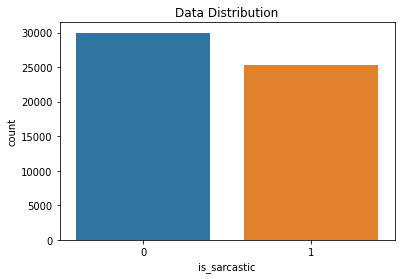

In [14]:
sns.countplot(x = "is_sarcastic", data = df)
plt.title("Data Distribution")

#**Tiền xử lí dữ liệu**

- Ta sẽ sử dụng thư viện nltk để hỗ trợ việc xử lí dữ liệu dạng text 
  - Thư viện Natural Language Toolkit (tạm dịch là Bộ công cụ Ngôn ngữ Tự nhiên, viết tắt NLTK) là một nền tảng dẫn đầu để xây dựng các chương trình Python làm việc với dữ liệu ngôn ngữ của con người. Thư viện cung cấp giao diện dễ sử dụng với hơn 50 tài nguyên từ vựng và ngữ liệu (corpora), điển hình là WordNet cùng với các thư viện thích hợp để xử lý bài toán phân loại, token hóa (tokenization), tìm từ gốc (stemming),… Thư viện NLTK còn là công cụ tuyệt vời để giảng dạy và giải quyết các bài toán về tính toán ngôn ngữ sử dụng Python.

- Trước hết ta sẽ tách các headline thành các token(từng chữ) bằng hàm RegexpTokenizer
- Sau đó ta sẽ tìm kiếm các stopwords và loại bỏ chúng
  - Stopword là gì? 
    - Stopword là những từ trong câu khi mất đi không gây ảnh hưởng đến nghĩa của câu.
    - Những stopword này đã được thống kê trong corpus của thư viện nltk.
- Tiếp đến sử dụng hàm PorterStemmer để đưa các token về dạng chuẩn của từ đó 
- Sau khi tiến hành xong các bước trên ta sẽ dùng thư viện TfidfVectorizer của sklearn để chuyển các token thành các ma trận TF-IDF và sử dụng hàm fit_transforms để tính tần suất xuất hiện của token này trong câu
  - tf–idf(term frequency – inverse document frequence) của một từ ,là một con số thu được qua thống kê thể hiện mức độ quan trọng của từ này trong một văn bản, mà bản thân văn bản đang xét nằm trong một tập hợp các văn bản.
- Cuối cùng tiến hành chia dữ liệu thành 2 phần train và test để tránh model bị overfitting

In [15]:
# import thư viện nltk và tiến hành download các stopword từ corpus
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Hàm xóa stopwords ra khỏi data:


In [16]:

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
# hàm xóa stopwords

# lấy các stopwords của tiếng anh từ thư viện 
stop_words =set(stopwords.words("english"))

# sử dụng hàm PorterStemmer của thư viện nltk để đưa các từ về dạng chuẩn.
  # ví dụ như walk , walked , walking đều chuẩn hóa về thành walk.
stemmer = PorterStemmer()

# dùng RegexpTokenizer để chia các headline thành các token
tokenizer = RegexpTokenizer(r'\w+')

#Hàm xóa stopwords 
def preprocess(text):
  word_list = []

  # tách thành các token của headline 
  tok = tokenizer.tokenize(text)

  # tìm xem trong các token này có từ nào là stopword không nếu phải loại bỏ , nếu không đưa chúng về dạng chuẩn
  for word in tok:
    if word not in stop_words:
      word_list.append(stemmer.stem(word))

  return " ".join(word_list)

## Tiến hành xóa những stopwords ra khỏi Data

In [17]:
# preprocess dữ liệu cần train 
x_data = X.apply(preprocess)
x_data.tail()

28614                      jew celebr rosh hashasha someth
28615    intern affair investig disappoint conspiraci g...
28616          beauti accept speech week came queer korean
28617    mar probe destroy orbit spielberg gate space p...
28618                                dad clarifi food stop
Name: headline, dtype: object

## Xử lí dữ liệu chuyển đổi ngôn ngữ tự nhiên thành  thành ma trận TF-IDF 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# sử dụng hàm TfidfVectorizer để chuyển các token thành các ma trận tf-idf feature.
vectorizer = TfidfVectorizer()

# sử dụng hàm fit_transform để tìm tần suất xuất hiện của token trong câu
x_data_tfidf=vectorizer.fit_transform(x_data)

x_data_tfidf

<55328x17940 sparse matrix of type '<class 'numpy.float64'>'
	with 394323 stored elements in Compressed Sparse Row format>

Công thức tính tfidf của một từ: tfidf=tf(t,d)*idf(t,D) với TF(t, d) = ( số lần từ t xuất hiện trong văn bản d) / (tổng số từ trong văn bản d) và IDF(t, D) = log_e( Tổng số văn bản trong tập mẫu D/ Số văn bản có chứa từ t )

##Chia dữ liệu thành 90% để train 10% để test ,sử dụng tham số random_state để để đảm bảo dữ liệu train và test một cách ngẫu nhiên

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data_tfidf, df['is_sarcastic'].values, test_size=0.1, random_state=42)

#**Chọn model để train cho data**

## DecisionTree

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
print(f"Training Score : {dt.score(X_train, y_train)}")
print(f"Test Score : {dt.score(X_test, y_test)}")

Training Score : 1.0
Test Score : 0.9643954455087655



## K-Nearest neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
KN=KNeighborsClassifier()
KN.fit(X_train,y_train)
print(f"Training Score : {KN.score(X_train, y_train)}")
print(f"Test Score : {KN.score(X_test, y_test)}")

Training Score : 0.7865046691434883
Test Score : 0.751852521236219


## Naive Bayes Classifier:

In [23]:
from sklearn.naive_bayes import BernoulliNB
BernModel = BernoulliNB()
BernModel.fit(X_train, y_train)
print(f"Training Score : {BernModel.score(X_train, y_train)}")
print(f"Test Score : {BernModel.score(X_test, y_test)}")

Training Score : 0.889185661210965
Test Score : 0.8514368335441894


## Logistic Regression:

In [24]:
from sklearn.linear_model import LogisticRegression
LogModel = LogisticRegression()
LogModel.fit(X_train,y_train)
print(f"Training Score : {LogModel.score(X_train, y_train)}")
print(f"Test Score : {LogModel.score(X_test, y_test)}")

Training Score : 0.8903504367908425
Test Score : 0.8449304174950298


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Random Forest Classifier:

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
print(f"Training Score : {rf_model.score(X_train, y_train)}")
print(f"Test Score : {rf_model.score(X_test, y_test)}")

Training Score : 1.0
Test Score : 0.9699981926622085


Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

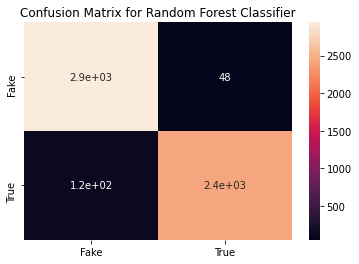

In [46]:
pred = rf_model.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm, index = ["Fake", "True"], columns=["Fake", "True"])
sns.heatmap(cm, annot = True)
plt.title("Confusion Matrix for Random Forest Classifier")

Random Forest classifier là model tốt nhất trong các model trên.
Vậy ta chọn model Random Forest Classifier để train trên dữ liệu datasets này.

# **Thu thập dữ liệu từ 2 trang web :** 
  - HuffPost : non-sarcastic
  - TheOnion : sarcastic

####**import thư viện :**
  - Request : gửi yêu cầu đến url
  - urlopen : mở url
  - BeautifulSoup : lấy headline từ các thẻ trong source của url

In [ ]:
from urllib.request import Request , urlopen 
from bs4 import BeautifulSoup

####**Scrap dữ liệu từ trang HuffPost**
- Ý tưởng : Scrap dữ liệu từng tab trong mục News của trang HuffPost UK
- Thực hiện :
  - Sử dụng vòng for để kiểm soát số tab cần scrap để tránh dữ liệu quá ít hoặc quá nhiều
  - Sau khi tìm được url của website cần scrap thì ta sẽ gửi yêu cầu đến url đó 
  - Tiếp đến mở url vừa được yêu cầu
  - Sử dụng BeautifullSoup để lấy source của website vừa mới được mở 
  - Một đoạn code chứa headline : **Judge Rejects White House Demand To Block John Bolton's New Book**

      ```<a class="card__link yr-card-headline" href="/entry/john-bolton-white-house-trump-book_uk_5eee269bc5b697d43e591553?utm_hp_ref=uk-news" target="_self" data-cpid="0d6874cb-8dbc-355e-89b3-76c1cbedf86a" data-rapid-pos="2" data-ylk="cpos:18;pos:2;elm:hdln;g:0d6874cb-8dbc-355e-89b3-76c1cbedf86a" data-rapid-sec="{&quot;col2&quot;:&quot;col2&quot;}" data-rapid-elm="hdln" data-rapid-g="0d6874cb-8dbc-355e-89b3-76c1cbedf86a" data-rapid_p="37" data-v9y="1">Judge Rejects White House Demand To Block John Bolton's New Book</a>```

  - Sau khi lấy được source của web, ta quan sát thấy các headline của trang này nằm trong thẻ <\a> với class_name = card__link yr-card-headline 
  - Vì thế ta dùng hàm find_all của thư viện BeautifullSoup để lấy ra tất các thẻ này
  - Tiếp theo ta tách headline bằng hàm text 
  - Cuối cùng kiểm tra xem headline vừa mới lấy ra có nằm trong Data chưa , nếu chưa thì đẩy nó và label của dữ liệu này là 0 vào data
- Kết quả : từ 50 tab của mục News ta lấy được 1600 headline

In [ ]:
# scrap data form HuffPost
huff_data = []

# sử dụng vòng lặp để load trang tiếp theo trong phần news 
for i in range(50):

  # định dạng url của phần news trong trang HuffPost với i tương ứng với số trang
  url = 'https://www.huffingtonpost.co.uk/news/'+ str(i) +'/?guccounter=2'

  # gửi request HTTP 1.1 đến url với header tự chỉnh 
  req = Request(url,headers={'User-Agent': 'ScrapData/3.0'})

  # mở url với thời gian chờ là 10s 
  page = urlopen(req,timeout=10)

  # sử dụng BeautifulSoup để lấy source của website với định dạng văn bản html
  soup = BeautifulSoup(page,"html.parser")

  # sử dụng hàm find_all để tìm tất cả thẻ a có name_class : card__link yr-card-headline
  headlines = soup.find_all('a',attrs={'class':'card__link yr-card-headline'})

  # tách headline từ thẻ và gán label cho nó 
  for hl in range(len(headlines)):

    # hàm text sẽ lấy ra phần text trong thẻ 
    headline = headlines[hl].text

    # kiểm tra headline có tồn tại trong data chưa 
    if headline not in huff_data:
      data = [headline,0]
      huff_data.append(data)

In [ ]:
print(huff_data[:10])
print(len(huff_data))

[["'We Don't Have Time For That' – How Jenrick's Officers Ignored Need For Affordable Housing", 0], ["Donald Trump Junior Desperately Tries To Spin His Dad's 'Walk Of Shame' Picture", 0], ['Coronavirus Cost Councils The Same As Five Years Of Austerity. Now, They Could Go Bust', 0], ["'Don't Tear The Pants Out Of It!' These Are The Absolute Best Bits From The Coronavirus Briefings", 0], ['Coronavirus Means These People Will Be On Mental Health Waiting Lists For Nearly A Year', 0], ["4 Years Later, Only 3 New Miles of 'Wall' And Not A Single Peso From Mexico", 0], ['Health Leaders Say UK Must Start Preparing For Second Covid-19 Wave', 0], ['Trump Spends Rally Downplaying Coronavirus And Making Racist Jokes', 0], ['Government Announces £85m To Help Rough Sleepers Through Coronavirus Pandemic', 0], ['Black Lives Matter: The History Of Taking A Knee', 0]]
1600


####**Scrap dữ liệu từ trang TheOnion**
- Ý tưởng : tương tự trang HuffPost lấy dữ liệu của từng tab của mục News-in-Brief
- Thực hiện : 
   - Khá giống với scrap dữ liệu của trang HuffPost
   - Tuy nhiên phần url của tab mới có dạng url gốc + 1 chuỗi ứng với tab đó 
   - Code của một More-Stroies button:

    ```<a class="sc-1out364-0 hMndXN js_link" data-ga="[[&quot;Story type page click&quot;,&quot;More stories click&quot;]]" href="?startTime=1592331480884" rel="next"><button class="j48i5d-2 fUFqcv button button--tertiary"><div class="j48i5d-1 fuDdQ"><span class="j48i5d-0 keLEgo">More stories</span><span class="iyvn34-0 bYIjtl"><svg xmlns="http://www.w3.org/2000/svg" width="18" height="18" aria-label="ChevronRight icon" viewBox="0 0 18 18"><path fill-rule="evenodd" d="M6.16 14.13a.5.5 0 1 0 .68.74l6-5.5a.5.5 0 0 0 0-.74l-6-5.5a.5.5 0 1 0-.68.74L11.76 9l-5.6 5.13z"></path></svg></span></div></button></a>```

   - Từ đây có thể thấy tail_url tab tiếp theo nằm trong href (?startTime=1592331480884)
   - Ta có thể tìm thông qua thẻ a và class_name = sc-1out364-0 hMndXN js_link tuy nhiên khi quan sát source có rất nhiều thẻ với class_name như vậy
   - Vì thế ta sẽ tìm thông qua data-ga="[[&quot;Story type page click&quot;,&quot;More stories click&quot;]]"
   -Từ đó có thể dùng hàm get('href') để lấy tail_url
   - Kiểm tra và đẩy dữ liệu vào data với label = 1
- Kết quả : sau khi scrap 80 tab ta cũng thu được 1600 headline 

In [ ]:
# scrap dữ liệu từ trang onion
onion_data= []

# đuôi url của mỗi tab 
tail_url = ''

# Sử dụng vòng lặp để scrap từng tab
for i in range(80):
  # url có định dạng url gốc của mục news-in-brief cộng với tail_url của mỗi tab, tab đầu tiên có đuôi trong từ tab 2 đuôi url sẽ ứng với 1 chuỗi số 
  url = 'https://www.theonion.com/c/news-in-brief' + tail_url

  # gửi yêu cầu đến url
  req = Request(url, headers={'ScrapData':'XYZ/3.0'})

  # mở url
  page = urlopen(req,timeout=10)

  # lấy source của web
  soup = BeautifulSoup(page,'html.parser')

  # tìm tất cả thẻ h2 với class_name = sc-759qgu-0 cYlVdn cw4lnv-6 eXwNRE
  headlines = soup.find_all('h2',attrs={'class':'sc-759qgu-0 cYlVdn cw4lnv-6 eXwNRE'})

  # tách headline và gắn label
  for hl in range(len(headlines)):

    # tách headline 
    headline = headlines[hl].text

    # kiểm tra headline có tồn tại trong data chưa 
    if headline not in onion_data:
      data = [headline,1]
      onion_data.append(data)

  # lấy tail_url của tab tiếp theo nằm trong href của thẻ a với data-ga = [["Story type page click","More stories click"]]
  # sử dụng hàm get('href') để lấy dữ liệu của href 
  tail_url = str(soup.find('a',attrs={'data-ga':'[["Story type page click","More stories click"]]'}).get('href'))

In [ ]:
print(onion_data[:10])
print(len(onion_data))

[['Nancy Pelosi Calls Jamaal Bowman To Scold Him For Winning Primary', 1], ['Gamers, We Just Spent 4 Days Trapped In A Rolled-Over Minivan And We’re Genuinely Pissed That Nobody Reported Us Missing When We Didn’t Cover The ‘Ratchet & Clank’ News', 1], ['Defiant Florida Officials Announce They Will Ignore Saudi Government Lockdown By Holding Hajj To Mecca', 1], ['Employee Leaves Performance Review With Clear, Identifiable Goal Of Surrendering To The Void', 1], ['Officials Warn Defunding Police Could Lead To Spike In Crime From Ex-Officers With No Outlet For Violence', 1], ['Realtor Thinks Flourishing Neighborhood Full Of Middle-Class Latino Families Has Real Turnaround Potential', 1], ['Study Finds Gap Widening Between Rich Pets And Poor Americans', 1], ['Heavily Armed Self-Help Gurus Demand America Reopens Their Hearts', 1], ['White House Announces Entire U.S. Populace Of 6,200 Attended Trump’s Tulsa Rally', 1], ['Facebook Announces Plan To Break Up U.S. Government Before It Becomes To

##**Ghi dữ liệu vào file CSV**
- Mount đến drive để lấy tệp cần ghi vào
- Dùng thư viện csv để chuyển data từ dạng list sang csv

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# impor thư viện csv
import csv

# các header của dữ liệu
Headers = [[ "Headline", "label"]]

# mở tệp Headlines_Data trong Drive với chế độ ghi
with open('/content/drive/My Drive/Sarcasm/Headline_sarcasm.xlsx', 'w', newline='') as file:
  # Sử dụng hàm writer để thực hiện ghi vào file   
    writer = csv.writer(file)

  # sử dụng wrirerows để ghi thành nhiều cột 
    

    # ghi onion data
    writer.writerows(onion_data)

    # ghi huffpost data
    writer.writerows(huff_data)

In [29]:
import pandas as pd
#Đọc file data đã lưu ở google driver
dataf=pd.read_csv('/content/drive/My Drive/Sarcasm/Headline_sarcasm.xlsx',header=None)
#Đặt tên cho 2 cột của data
dataf.columns=['headline','is_sarcastic']
print(dataf)

                                               headline  is_sarcastic
0     Officials Warn Defunding Police Could Lead To ...             1
1     Realtor Thinks Flourishing Neighborhood Full O...             1
2     Study Finds Gap Widening Between Rich Pets And...             1
3     Heavily Armed Self-Help Gurus Demand America R...             1
4     White House Announces Entire U.S. Populace Of ...             1
...                                                 ...           ...
3195  I Have Zero Patience For Middle-Class Whinging...             0
3196  Why Boris Johnson Doesn’t Want To Peak Too Soo...             0
3197  Coronavirus Hides The Budget In Plain Sight, W...             0
3198  Why Donald Trump’s Coronavirus Travel Ban Won’...             0
3199    Two New Coronavirus Deaths Confirmed In England             0

[3200 rows x 2 columns]


In [30]:
x1=dataf[:1000]
x2=dataf[2200:3200]
test=pd.concat([x1,x2])

In [31]:
#Tiến hành xóa những stop_words của dữ liệu
x1_test=test['headline'].apply(preprocess)
x1_test

0       offici warn defund polic could lead To spike I...
1       realtor think flourish neighborhood full Of mi...
2       studi find gap widen between rich pet and poor...
3       heavili arm self help guru demand america reop...
4       white hous announc entir U S populac Of 6 200 ...
                              ...                        
3195    I have zero patienc for middl class whing abou...
3196    whi bori johnson doesn want To peak too soon O...
3197    coronaviru hide the budget In plain sight with...
3198      whi donald trump coronaviru travel ban won work
3199          two new coronaviru death confirm In england
Name: headline, Length: 2000, dtype: object

In [32]:
#Số hóa dữ liệu: chuyển đổi ngôn ngữ tự nhiên thành thành ma trận các tính năng TF-IDF
x1_test_tfidf = vectorizer.transform(x1_test)
x1_test_tfidf

<2000x17940 sparse matrix of type '<class 'numpy.float64'>'
	with 17795 stored elements in Compressed Sparse Row format>

In [33]:
print(x1_test_tfidf)

  (0, 17318)	0.22963730081650208
  (0, 17136)	0.2463139642013744
  (0, 14952)	0.3402858450536646
  (0, 12174)	0.21235456178068954
  (0, 11394)	0.33790208951111084
  (0, 11196)	0.23140246769349612
  (0, 11193)	0.2140104275805705
  (0, 9095)	0.2343588764350458
  (0, 7934)	0.39973106438218065
  (0, 5528)	0.2549935444844295
  (0, 4294)	0.35174153874423864
  (0, 3878)	0.25913049516121844
  (0, 3743)	0.20391272513240466
  (1, 16441)	0.3867553371048772
  (1, 15956)	0.21121324766918487
  (1, 12934)	0.3691270199107559
  (1, 12926)	0.22604015086485288
  (1, 12296)	0.297506251735453
  (1, 10804)	0.2883125005115685
  (1, 10155)	0.2451651434734154
  (1, 9050)	0.28229856589619673
  (1, 6348)	0.2483973903537935
  (1, 6059)	0.3741353509067004
  (1, 5701)	0.20227754718602428
  (1, 3220)	0.25383683837492277
  :	:
  (1995, 7258)	0.5456109331530601
  (1995, 3220)	0.35809759030373206
  (1996, 17296)	0.29409258863606996
  (1996, 14832)	0.41097635939291577
  (1996, 11761)	0.4837140615664964
  (1996, 8482)	0.

In [34]:
y1_test=test['is_sarcastic']
y1_test.shape

(2000,)

#**Đối chiếu performance của model trên dataset đã cho và trên 2000 headine mới**

In [47]:
print(f"Test Score : {rf_model.score(X_test, y_test)}")
print(f"New Test Score : {rf_model.score(x1_test_tfidf, y1_test)}")

Test Score : 0.9699981926622085
New Test Score : 0.73


Text(0.5, 1.0, 'Confusion Matrix for Voting Classifier')

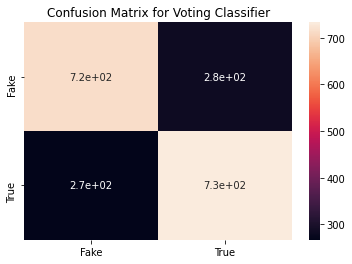

In [48]:
pred =rf.predict(x1_test_tfidf)
cm=metrics.confusion_matrix(y1_test,pred)
cm = pd.DataFrame(cm, index = ["Fake", "True"], columns=["Fake", "True"])
sns.heatmap(cm, annot = True)
plt.title("Confusion Matrix for Voting Classifier")

###Nhận xét: performance test trên 2000 headlines tự cào thấp hơn nhiều đối với test_set trên datasets có sẵn: 73% ~ 96%

### Theo nhóm nghĩ: lí do khiến performance trên 2000 headlines mới thấp hơn


*   Có thể xuất hiện nhiều từ mới mà trong dataset không có vì dataset trên kaggle do người ta thu thập lâu rồi còn mình thu thập dữ liệu là gần đây




#**Viết ứng dụng**

- Yêu cầu người dùng nhập headline cần kiểm tra vào 
- Chuyển headline từ dạng string sang list để dùng thư viện pandas tạo thành dataframe
- Tiền xử lí dữ liệu cho headline giống như data được train
- Dùng model của mình để predict headline 
	- predict = 1 thì headline có tính chấm biếm
	- predict = 0 thì headline không có tính châm biếm

In [49]:
print('Nhập vào headline cần kiểm tra!!!')

# Nhập vào headline
Headline_str = input()

# Chuyển headline thành dạng dataframe
Headline_list = [Headline_str]
df_app = pd.DataFrame(Headline_list)

# Tiền xử lí headline
Test_app = df_app[0].apply(preprocess)
Test_app_tfidf = vectorizer.transform(Test_app)

# Predict healine
result_app = rf_model.predict(Test_app_tfidf)

# Kết quả 
if result_app:
  print("Sarcastic")
else:
  print("None-Sarcastic")

Nhập vào headline cần kiểm tra!!!
Medical Staff Share Cheerful Videos During Coronavirus
None-Sarcastic


#**Tham khảo**
- Dataset : https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection
- Code : https://www.kaggle.com/ebshirani/tf-idf-random-forest-nb-logistic-reg-and-lstms